In [115]:
#imports
import numpy as np
import matplotlib.pyplot as plt

In [116]:
def csv_to_numpy_with_names(filename: str):
    data = np.genfromtxt(filename, delimiter=',', dtype=np.float64, names=True)
    names = data.dtype.names
    array = data.view((data.dtype[0], len(data.dtype.names)))
    return array, names

In [117]:
#get data from .csv file
train_data, names = csv_to_numpy_with_names("./dataset/exoTrain.csv")
test_data = csv_to_numpy_with_names("./dataset/exoTest.csv")[0]

In [118]:
#data info
print("Column names:")
print(names)
print()
print("=====================================================================================================================")
print()
print("Data:")
print(train_data)
print()
print("=====================================================================================================================")
print()
print("Train shape:")
print(train_data.shape)
print()
print("Test shape:")
print(test_data.shape)

Column names:
('LABEL', 'FLUX1', 'FLUX2', 'FLUX3', 'FLUX4', 'FLUX5', 'FLUX6', 'FLUX7', 'FLUX8', 'FLUX9', 'FLUX10', 'FLUX11', 'FLUX12', 'FLUX13', 'FLUX14', 'FLUX15', 'FLUX16', 'FLUX17', 'FLUX18', 'FLUX19', 'FLUX20', 'FLUX21', 'FLUX22', 'FLUX23', 'FLUX24', 'FLUX25', 'FLUX26', 'FLUX27', 'FLUX28', 'FLUX29', 'FLUX30', 'FLUX31', 'FLUX32', 'FLUX33', 'FLUX34', 'FLUX35', 'FLUX36', 'FLUX37', 'FLUX38', 'FLUX39', 'FLUX40', 'FLUX41', 'FLUX42', 'FLUX43', 'FLUX44', 'FLUX45', 'FLUX46', 'FLUX47', 'FLUX48', 'FLUX49', 'FLUX50', 'FLUX51', 'FLUX52', 'FLUX53', 'FLUX54', 'FLUX55', 'FLUX56', 'FLUX57', 'FLUX58', 'FLUX59', 'FLUX60', 'FLUX61', 'FLUX62', 'FLUX63', 'FLUX64', 'FLUX65', 'FLUX66', 'FLUX67', 'FLUX68', 'FLUX69', 'FLUX70', 'FLUX71', 'FLUX72', 'FLUX73', 'FLUX74', 'FLUX75', 'FLUX76', 'FLUX77', 'FLUX78', 'FLUX79', 'FLUX80', 'FLUX81', 'FLUX82', 'FLUX83', 'FLUX84', 'FLUX85', 'FLUX86', 'FLUX87', 'FLUX88', 'FLUX89', 'FLUX90', 'FLUX91', 'FLUX92', 'FLUX93', 'FLUX94', 'FLUX95', 'FLUX96', 'FLUX97', 'FLUX98', 'FLUX

In [119]:
#get labels
X_train, y_train = np.delete(train_data, 0, axis=1), np.take(train_data, 0, axis=1).astype(int)
X_test, y_test = np.delete(test_data, 0, axis=1), np.take(test_data, 0, axis=1).astype(int)

In [120]:
def show_charts(X, y, indexes, show_labels=False):
    for index in indexes:
        plt.plot(X[index])
        plt.show()
        print(f"Label: {y[index]} {"(Planet(s) probably exists)" if y[index] > 0 and show_labels else "(No planets)" if show_labels else ""}")

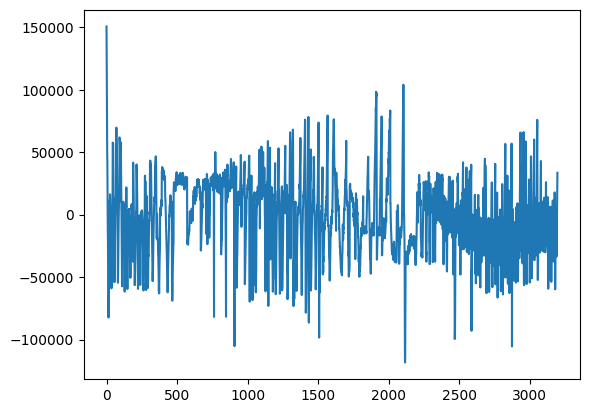

Label: 2 


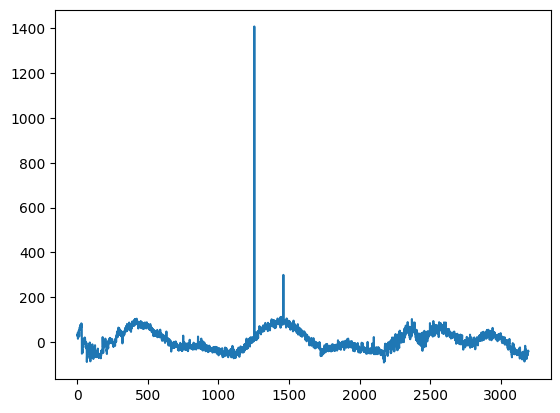

Label: 1 


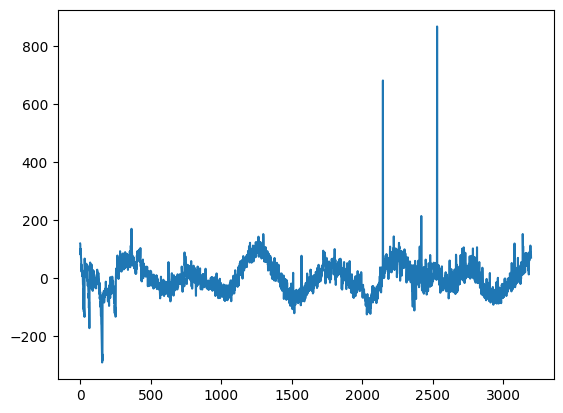

Label: 1 


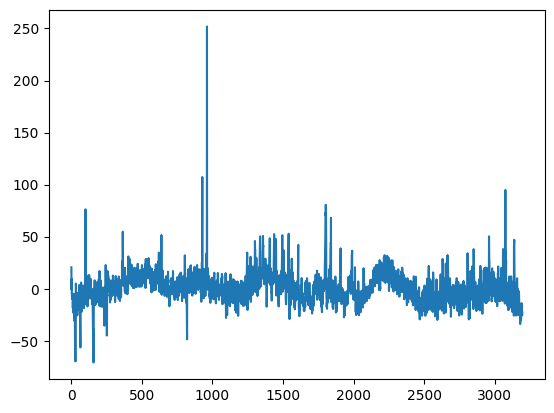

Label: 1 


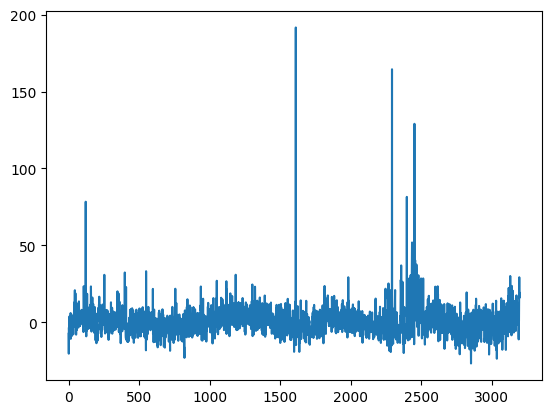

Label: 1 


In [121]:
#charts
chart_indexes = [np.random.randint(0, 1000) for _ in range(5)]
show_charts(X_train, y_train, chart_indexes)

In [122]:
def remove_outliers(X_data):
    X = np.empty(X_data.shape)
    for i in range(len(X_data)):
        q1 = np.percentile(X_data[i], 25)
        q3 = np.percentile(X_data[i], 75)
        iqr = q3 - q1

        min_val = q1 - 1.5 * iqr
        max_val = q3 + 1.5 * iqr

        for j in range(1, len(X_data[i])-1):
            if X_data[i][j] < min_val or X_data[i][j] > max_val:
                # X[i][j] = (X_data[i][j-1] + X_data[i][j+1]) / 2
                X[i][j] = X_data[i][j-1]
            else:
                X[i][j] = X_data[i][j]
    return X
    
def normalize_01(data):
    min_val = min(data)
    max_val = max(data)
    d = max_val - min_val
    return (data - min_val) / d

def normalize_X_01(X_data):
    X = np.empty(X_data.shape)
    for i in range(len(X_data)):
        X[i] = normalize_01(X_data[i])
    return X

def prepare_X_data(X_data):
    X = remove_outliers(X_data)
    X = normalize_X_01(X)
    return X
    

In [123]:
#preparing data
X_train, y_train = prepare_X_data(X_train), normalize_01(y_train).astype(int)
X_test, y_test = prepare_X_data(X_test), normalize_01(y_test).astype(int)

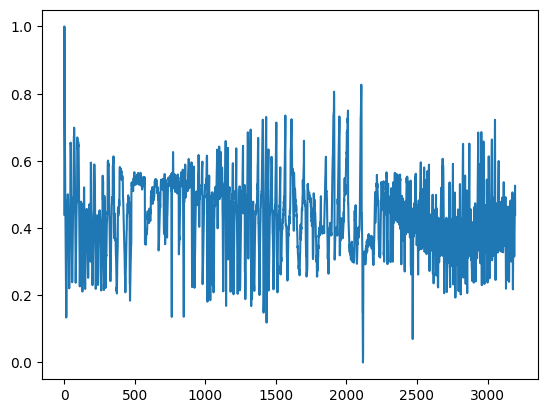

Label: 1 (Planet(s) probably exists)


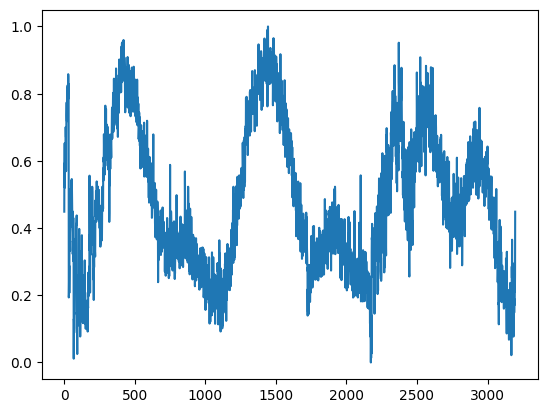

Label: 0 (No planets)


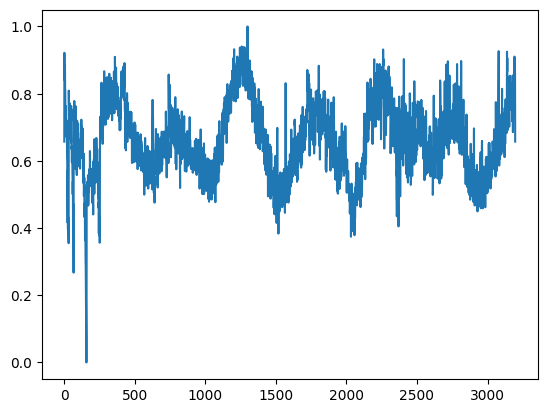

Label: 0 (No planets)


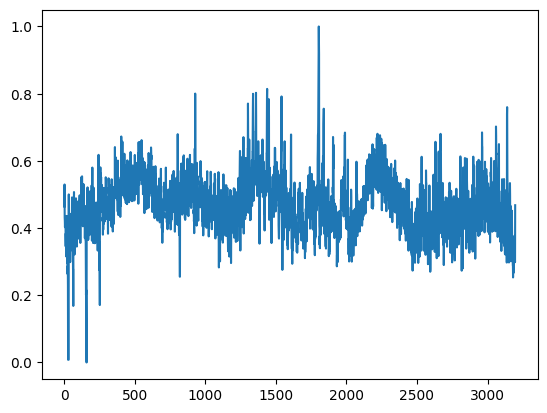

Label: 0 (No planets)


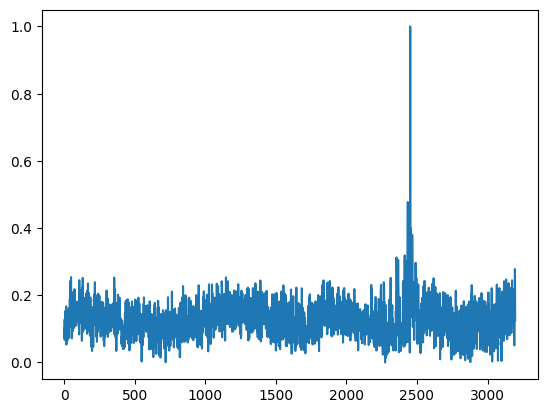

Label: 0 (No planets)


In [124]:
#charts
show_charts(X_train, y_train, chart_indexes, show_labels=True)
